In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm

from typing import List
from collections import Counter
from itertools import chain
import umap.umap_ as umap
import matplotlib.pyplot as plt


def build_vocab(reviews: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in reviews]))
    vocab = Counter(words)
    return vocab




In [2]:
df1 = pd.read_csv('shopee_reviews.csv')
df1.columns = ['mark', 'review']

In [3]:
res = pd.DataFrame(columns=['mark', 'review'])
for mark in range(1, 5 + 1):
    res = res.append(df1[df1.mark == mark].sample(10000), ignore_index=True)
df1 = res

In [4]:
vocab = build_vocab(df1.review.tolist())
print(len(vocab))
list(vocab.items())[:10]

48142


[('Took', 551),
 ('super', 665),
 ('long.', 274),
 ('And', 625),
 ('when', 2660),
 ('I', 9794),
 ('wanna', 46),
 ('cancel', 100),
 ('seller', 4048),
 ('reject', 6)]

In [5]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
eng_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [7]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    cleaned_words = []
    for word in text.split():
        if word in eng_stopwords:
            continue
        cleaned_words.append(stemmer.stem(word))

    return ' '.join(cleaned_words)


texts = []
for text in tqdm(df1.review.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(10)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:14<00:00, 3515.54it/s]


17792


[('good', 11599),
 ('receiv', 11212),
 ('item', 10039),
 ('deliveri', 8722),
 ('seller', 7114),
 ('order', 5873),
 ('qualiti', 5732),
 ('size', 5151),
 ('fast', 5036),
 ('product', 4588)]

In [8]:
cleaned_vocab = list(filter(lambda x: x[1] > 3, vocab.items()))
cleaned_words = [k for k, v in cleaned_vocab]
print(len(cleaned_words))

4552


In [10]:
from gensim.models import Word2Vec

def filtered_text(text):
    return list(filter(lambda word: word in cleaned_words, text.split()))

model = Word2Vec(sentences=[filtered_text(text) for text in tqdm(texts)],
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=40, 
                 min_count=1
                 )
print('Lenght of vector', model.wv.vectors.shape)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 6962.83it/s]


Lenght of vector (4552, 100)


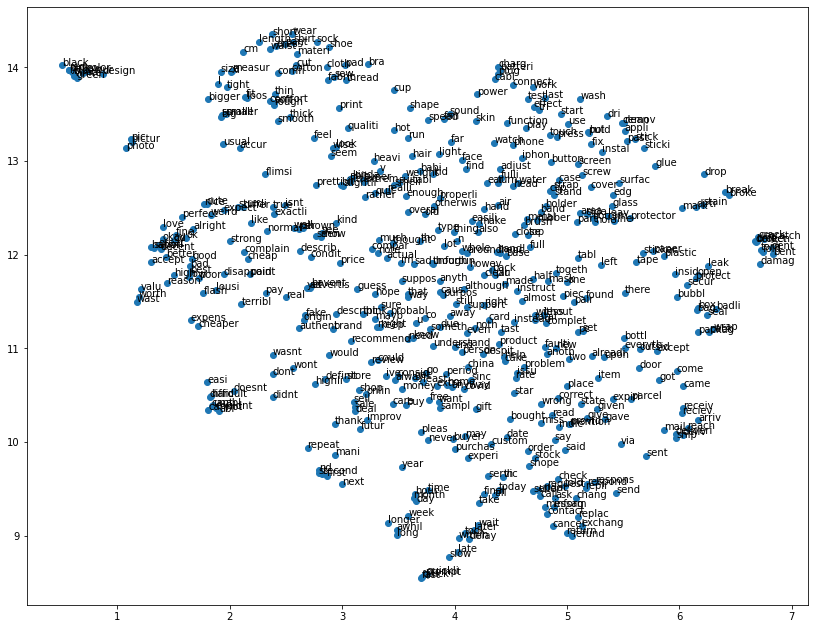

In [11]:
points = umap.UMAP(random_state=42).fit_transform(model.wv.vectors[:500])
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(model.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class Utils:
    
    def __init__(self, words, word_to_vec_f):
        self.words_dict = dict(zip(words, range(len(words))))
        self.converter = word_to_vec_f
        self.cosin_matrix = self.build_cosine_matrix(words, word_to_vec_f)
        
    def get_embed(self, word):
        return self.converter(word)
        
    def build_cosine_matrix(self, words, func):
        np_words = np.array([func(word) for word in tqdm(words)])
        return cosine_similarity(np_words, np_words)

    def common(self, word1, word2, f):
        a, b = np.array(self.converter(word1)), np.array(self.converter(word2))
        return f(a, b)
    
    def subwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a+b)

    def sumwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a+b)
    
    def similar_helper(self, vector):
        temp = [(w, cosine_similarity([self.converter(w)], [vector])[0][0]) for w in self.words_dict.keys()]
        temp.sort(key=lambda x:-x[1])
        return temp
    
    def similar(self, vector, count=1):
        temp = self.similar_helper(vector)
        return temp[2:2+count]
    
    def unsimilar(self, vector, count=1):
        temp = self.similar_helper(word)
        return sorted(temp[-count-2:-2], key=lambda x: x[1])
    
    def close_helper(self, word):
        word_index = self.words_dict[word]
        temp = [(i, w, self.cosin_matrix[word_index][i]) for w, i in filter(lambda x: x[0] != word, self.words_dict.items())]
        temp.sort(key=lambda x:-x[2])
        return temp
    
    def close(self, word, count=1):
        temp = self.close_helper(word)
        return temp[:count]
    
    def unclose(self, word, count=1):
        temp = self.close_helper(word)
        return sorted(temp[-count:], key=lambda x: x[2])

In [13]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model_bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [14]:
len(list(tokenizer.vocab.keys()))

30522

In [15]:
gensim_utils = Utils(cleaned_words, model.wv.get_vector)

100%|███████████████████████████████████████████████████████████████████████████| 4552/4552 [00:00<00:00, 25041.54it/s]


In [16]:
def make_word_embedding(word: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(word)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    return outputs[2][-1].squeeze(0).sum(dim=0).tolist()

bert_utils = Utils(cleaned_words, make_word_embedding)

100%|██████████████████████████████████████████████████████████████████████████████| 4552/4552 [05:45<00:00, 13.19it/s]


In [17]:
gensim_utils.sumwords("green", "blue")

array([-0.0693432 , -3.2199316 ,  2.934847  ,  4.653715  ,  0.8592229 ,
       -0.44880867,  0.6182952 , -1.7059577 ,  2.5569873 ,  0.37592876,
        2.4578316 ,  2.0169601 ,  3.040003  ,  3.233069  ,  1.4007978 ,
        3.262563  , -4.847721  , -1.5569267 ,  0.22835845,  1.3711705 ,
        3.5644424 ,  0.09215246, -2.6538808 ,  0.5627117 , -1.5673292 ,
       -0.6867475 ,  4.3664665 ,  2.4229922 ,  1.8067417 , -5.42013   ,
       -4.6975603 ,  1.3412968 , -1.1887987 ,  0.85542846, -5.041425  ,
       -0.39159957, -3.5099177 ,  1.8172089 , -1.8387414 , -2.5195315 ,
       -0.16779664,  2.6256146 , -0.93716264, -2.2245574 ,  1.1186308 ,
        2.1285667 ,  6.8021984 , -0.7441622 , -0.98995656,  1.8198489 ,
        0.934302  , -3.2467716 , -3.184642  ,  5.158186  ,  0.23438665,
        1.4904194 , -3.140645  , -1.0661802 ,  1.4725921 ,  2.2879133 ,
       -0.5704954 ,  0.58133245,  2.879783  , -3.3591251 , -0.15112178,
        0.5815605 ,  0.5495118 , -0.16317187, -0.88736165, -3.09

In [18]:
bert_utils.sumwords("green", "blue")

array([-2.03892063e-01, -3.25684547e-02, -1.65935534e+00,  4.32033606e-01,
        1.07169271e-01,  2.94318128e-01,  1.46816164e+00,  1.61791277e+00,
       -1.03367770e+00, -2.32867002e-02, -6.06436580e-02, -1.72204322e+00,
       -9.33522224e-01,  2.94937283e-01, -2.77580556e-01,  1.59479356e+00,
        9.20780465e-01, -4.81475472e-01, -2.61451349e-01, -6.39876306e-01,
        4.63206291e-01, -1.19270357e+00, -2.72330344e-01,  6.39162660e-02,
       -4.17432502e-01, -7.71861613e-01, -4.24021706e-01, -6.67046532e-02,
       -6.62748575e-01, -5.25288522e-01,  3.87873560e-01, -1.03554845e+00,
        1.69460356e-01, -5.36632925e-01,  4.98875767e-01,  1.93465817e+00,
        1.30996197e-01, -9.09210384e-01, -1.46233422e+00, -4.48303446e-01,
        1.93115324e-01, -2.18484588e-01, -6.38123259e-01,  2.37202018e-01,
        5.40071607e-01,  6.23127520e-01,  1.34346002e+00,  1.77014410e-01,
       -1.82514511e-01, -7.38514319e-01,  4.30147499e-02,  1.18255365e+00,
        1.18185103e+00, -

In [19]:
gensim_utils.similar(gensim_utils.subwords("good", "fast"), count = 5)

[('speedi', 0.60124177),
 ('quick', 0.5868174),
 ('great', 0.57425946),
 ('gd', 0.5672647),
 ('prompt', 0.5652696)]

In [ ]:
bert_utils.similar(bert_utils.subwords("good", "fast"), count = 5)

In [37]:
gensim_utils.close("good", count=10)

[(1244, 'great', 0.7086842),
 (463, 'gd', 0.64310324),
 (103, 'bad', 0.573548),
 (1758, 'excel', 0.56607807),
 (734, 'ok', 0.5228502),
 (2223, 'decent', 0.51201755),
 (381, 'nice', 0.50377774),
 (1321, 'okay', 0.489944),
 (2186, 'alright', 0.48138797),
 (1816, 'satisfactori', 0.47715706)]

In [38]:
bert_utils.close("good", count=10)

[(3801, 'goodwil', 0.8346412545212377),
 (3186, 'goodi', 0.8302492921281555),
 (4499, 'goodthank', 0.7717763450124447),
 (4550, 'goodgood', 0.7717021916885012),
 (4197, 'goodfast', 0.7462025914399172),
 (2956, 'goodbut', 0.7310788679270642),
 (2460, 'vid', 0.7208085786048952),
 (4269, 'boyish', 0.7195082214313216),
 (922, 'goodveri', 0.7158323318322025),
 (2441, 'bird', 0.712067016408946)]

In [21]:
corpus_vocab = sorted(cleaned_vocab, key=lambda x: -x[1])[:2000]
print(corpus_vocab[:10])
corpus = [i[0] for i in corpus_vocab]

[('good', 11599), ('receiv', 11212), ('item', 10039), ('deliveri', 8722), ('seller', 7114), ('order', 5873), ('qualiti', 5732), ('size', 5151), ('fast', 5036), ('product', 4588)]


In [22]:
embeddings = [gensim_utils.get_embed(i) for i in corpus]
print(embeddings[0])

[ 0.5094315   1.390144    0.6267637  -0.95130694  1.1268094   1.3901732
 -0.8387409   0.03314294 -0.968969    0.6848089  -0.23984087 -0.20855367
  0.16211943  0.6673964  -0.08645559  0.13075455 -0.35403657  0.3074092
 -0.1794598  -0.77488583  1.2630084   1.00421    -0.07914759 -0.33081746
 -1.006464   -0.07219562  0.11232992  0.46076337  0.34989488  1.4117324
 -0.06498589 -2.9589343   0.5109633  -0.64047086  0.34426123  0.6396825
  1.9297405   0.50163347 -0.16538583  0.3134478  -0.41426033 -0.78386045
  0.5339169  -0.02101671 -0.46620205 -0.04936996 -2.671027    1.3509771
 -0.99108654 -1.6253439  -0.86595136 -0.4869675   0.6353107   1.1109982
  0.67139584  1.0767452  -0.6368876  -1.0554711   0.3316718  -0.8790741
  1.8281084   0.5259089   1.4272416  -0.38655695 -0.4294161   0.91652846
  1.5526621  -1.3420496  -0.93949354  0.571483    1.1796916  -1.0701488
 -0.21557245 -1.1689504   0.24579622  1.7916989  -0.85233265  2.6452992
 -0.7256718   0.64988875 -0.27918613 -0.9530501  -0.82572114

In [23]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('op')

writer.add_embedding(embeddings,metadata=corpus)
writer.close()